In [5]:
# Google Colab에서 노트북을 실행하실 때에는 
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
%matplotlib inline

강화 학습 (DQN) 튜토리얼
========================

**Author**: [Adam Paszke](https://github.com/apaszke), [Mark Towers](https://github.com/pseudo-rnd-thoughts)

:   **번역**: [황성수](https://github.com/adonisues),
    [박정환](https://github.com/9bow)

이 튜토리얼에서는 [Gymnasium](https://gymnasium.farama.org) 의
CartPole-v1 태스크에서 DQN (Deep Q Learning) 에이전트를 학습하는데
PyTorch를 사용하는 방법을 보여드립니다.

**태스크**

에이전트는 연결된 막대가 똑바로 서 있도록 카트를 왼쪽이나 오른쪽으로
움직이는 두 가지 동작 중 하나를 선택해야 합니다. 환경 설정과 다른 더
까다로운 환경에 대한 자세한 내용은 [Gymnasium
웹사이트](https://gymnasium.farama.org/environments/classic_control/cart_pole/)
에서 찾아볼 수 있습니다.

![CartPole](https://tutorials.pytorch.kr/_static/img/cartpole.gif)

에이전트가 현재 환경 상태를 관찰하고 행동을 선택하면, 환경이 새로운
상태로 *전환* 되고 작업의 결과를 나타내는 보상도 반환됩니다. 이
태스크에서 매 타임스텝 증가마다 보상이 +1이 되고, 만약 막대가 너무 멀리
떨어지거나 카트가 중심에서 2.4 유닛 이상 멀어지면 환경이 중단됩니다.
이것은 더 좋은 시나리오가 더 오랫동안 더 많은 보상을 축적하는 것을
의미합니다.

카트폴 태스크는 에이전트에 대한 입력이 환경 상태(위치, 속도 등)를
나타내는 4개의 실제 값이 되도록 설계되었습니다. 스케일링 없이 이 4개의
입력을 받아 각 동작에 대해 하나씩, 총 2개의 출력을 가진 완전히 연결된
작은 신경망에 통과시킵니다. 신경망은 주어진 입력에 대해, 각 동작에 대한
예상값을 예측하도록 훈련됩니다. 가장 높은 예측값을 갖는 동작이
선택됩니다.

**패키지**

먼저 필요한 패키지를 가져옵니다. 첫째, 환경 구성을 위해 pip를 사용해
설치한 [gymnasium](https://gymnasium.farama.org/) 이 필요합니다. 이는
OpenAI Gym로부터 파생(fork)된 것으로, Gym v0.19부터 같은 팀에서
유지보수를 하고 있습니다. Google Colab에서 이 튜토리얼을 실행하고
있다면, 다음을 실행해 설치할 수 있습니다:

``` {.sourceCode .bash}
%%bash
pip3 install gym[classic_control]
```

또한 PyTorch에서 다음을 사용합니다:

-   신경망 (`torch.nn`)
-   최적화 (`torch.optim`)
-   자동 미분 (`torch.autograd`)
-   시각 태스크를 위한 유틸리티들 (`torchvision` - [a separate
    package](https://github.com/pytorch/vision)).


In [13]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

재현 메모리(Replay Memory)
==========================

우리는 DQN 학습을 위해 경험 재현 메모리를 사용할 것입니다. 에이전트가
관찰한 전환(transition)을 저장하고 나중에 이 데이터를 재사용할 수
있습니다. 무작위로 샘플링하면 배치를 구성하는 전환들이
비상관(decorrelated)하게 됩니다. 이것이 DQN 학습 절차를 크게 안정시키고
향상시키는 것으로 나타났습니다.

이를 위해서 두개의 클래스가 필요합니다:

-   `Transition` - 우리 환경에서 단일 전환을 나타내도록 명명된 튜플.
    그것은 화면의 차이인 state로 (state, action) 쌍을 (next\_state,
    reward) 결과로 매핑합니다.
-   `ReplayMemory` - 최근 관찰된 전이를 보관 유지하는 제한된 크기의 순환
    버퍼. 또한 학습을 위한 전환의 무작위 배치를 선택하기위한
    `.sample ()` 메소드를 구현합니다.


In [14]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

이제 모델을 정의합시다. 그러나 먼저 DQN이 무엇인지 간단히 요약해
보겠습니다.

DQN 알고리즘
============

우리의 환경은 결정론적이므로 여기에 제시된 모든 방정식은 단순화를 위해
결정론적으로 공식화됩니다. 강화 학습 자료은 환경에서 확률론적 전환에
대한 기대값(expectation)도 포함할 것입니다.

우리의 목표는 할인된 누적 보상 (discounted cumulative reward)을
극대화하려는 정책(policy)을 학습하는 것입니다.
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, 여기서 $R_{t_0}$
는 *반환(return)* 입니다. 할인 상수, $\gamma$, 는 $0$ 과 $1$ 의 상수여야
합니다. $\gamma$ 가 낮을수록 에이전트에게는 불확실한 먼 미래의 보상은
상당히 확신할 수 있는 가까운 미래의 보상보다 덜 중요해집니다. 또한,
에이전트가 시간적으로 가까운 시점의 보상을, 동일한 양의 먼 미래의
보상보다 먼저 수집하도록 장려합니다.

Q-learning의 주요 아이디어는 만일 함수
$Q^*: State \times Action \rightarrow \mathbb{R}$ 를 가지고 있다면
반환이 어떻게 될지 알려줄 수 있고, 만약 주어진 상태(state)에서
행동(action)을 한다면, 보상을 최대화하는 정책을 쉽게 구축할 수 있습니다:

$$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$$

그러나 세계(world)에 관한 모든 것을 알지 못하기 때문에, $Q^*$ 에 도달할
수 없습니다. 그러나 신경망은 범용 함수 근사자(universal function
approximator)이기 때문에 간단하게 생성하고 $Q^*$ 를 닮도록 학습할 수
있습니다.

학습 업데이트 규칙으로, 일부 정책을 위한 모든 $Q$ 함수가 Bellman
방정식을 준수한다는 사실을 사용할 것입니다:

$$Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))$$

평등(equality)의 두 측면 사이의 차이는 시간차 오류(temporal difference
error), $\delta$ 입니다.:

$$\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))$$

오류를 최소화하기 위해서 [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss) 를 사용합니다. Huber
loss 는 오류가 작으면 평균 제곱 오차( mean squared error)와 같이
동작하고 오류가 클 때는 평균 절대 오류와 유사합니다. - 이것은 $Q$ 의
추정이 매우 혼란스러울 때 이상 값에 더 강건하게 합니다. 재현 메모리에서
샘플링한 전환 배치 $B$ 에서 이것을 계산합니다:

$$\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)$$

$$\begin{aligned}
\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
  \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
  |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}
\end{aligned}$$

Q-네트워크
----------

우리 모델은 현재와 이전 스크린 패치의 차이를 취하는 순연결(feed-forward)
신경망입니다. 두가지 출력 $Q(s, \mathrm{left})$ 와
$Q(s, \mathrm{right})$ 가 있습니다. (여기서 $s$ 는 네트워크의
입력입니다) 결과적으로 네트워크는 주어진 현재 입력에서 각 행동의
*기대값* 을 예측하려고 합니다.


In [15]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐됩니다.
    # ([[left0exp,right0exp]...]) 를 반환합니다.
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

학습
====

하이퍼 파라미터와 유틸리티
--------------------------

이 셀은 모델과 최적화기를 인스턴스화하고 일부 유틸리티를 정의합니다:

-   `select_action` - Epsilon Greedy 정책에 따라 행동을 선택합니다.
    간단히 말해서, 가끔 모델을 사용하여 행동을 선택하고 때로는 단지
    하나를 균일하게 샘플링할 것입니다. 임의의 액션을 선택할 확률은
    `EPS_START` 에서 시작해서 `EPS_END` 를 향해 지수적으로 감소할
    것입니다. `EPS_DECAY` 는 감쇠 속도를 제어합니다.
-   `plot_durations` - 지난 100개 에피소드의 평균(공식 평가에서 사용 된
    수치)에 따른 에피소드의 지속을 도표로 그리기 위한 헬퍼. 도표는 기본
    훈련 루프가 포함된 셀 밑에 있으며, 매 에피소드마다 업데이트됩니다.


In [16]:
# BATCH_SIZE는 리플레이 버퍼에서 샘플링된 트랜지션의 수입니다.
# GAMMA는 이전 섹션에서 언급한 할인 계수입니다.
# EPS_START는 엡실론의 시작 값입니다.
# EPS_END는 엡실론의 최종 값입니다.
# EPS_DECAY는 엡실론의 지수 감쇠(exponential decay) 속도 제어하며, 높을수록 감쇠 속도가 느립니다.
# TAU는 목표 네트워크의 업데이트 속도입니다.
# LR은 ``AdamW`` 옵티마이저의 학습율(learning rate)입니다.
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# gym 행동 공간에서 행동의 숫자를 얻습니다.
n_actions = env.action_space.n
# 상태 관측 횟수를 얻습니다.
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

학습 루프
=========

최종적으로 모델 학습을 위한 코드.

여기서, 최적화의 한 단계를 수행하는 `optimize_model` 함수를 찾을 수
있습니다. 먼저 배치 하나를 샘플링하고 모든 Tensor를 하나로 연결하고
$Q(s_t, a_t)$ 와 $V(s_{t+1}) = \max_a Q(s_{t+1}, a)$ 를 계산하고
그것들을 손실로 합칩니다. 우리가 설정한 정의에 따르면 만약 $s$ 가 마지막
상태라면 $V(s) = 0$ 입니다. 또한 안정성 추가 위한 $V(s_{t+1})$ 계산을
위해 목표 네트워크를 사용합니다. 대상 네트워크는 이전에 정의한
하이퍼파라미터 `TAU` 에 의해 제어되는 [소프트
업데이트](https://arxiv.org/pdf/1509.02971.pdf) 로 모든 단계에서
업데이트됩니다.


In [17]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). 이것은 batch-array의 Transitions을 Transition의 batch-arrays로
    # 전환합니다.
    batch = Transition(*zip(*transitions))

    # 최종이 아닌 상태의 마스크를 계산하고 배치 요소를 연결합니다
    # (최종 상태는 시뮬레이션이 종료 된 이후의 상태)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택합니다.
    # 이들은 policy_net에 따라 각 배치 상태에 대해 선택된 행동입니다.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
    # max(1).values로 최고의 보상을 선택하십시오.
    # 이것은 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖습니다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    # 변화도 클리핑 바꿔치기
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

아래에서 주요 학습 루프를 찾을 수 있습니다. 처음으로 환경을 재설정하고
초기 `state` Tensor를 얻습니다. 그런 다음 행동을 샘플링하고, 그것을
실행하고, 다음 상태와 보상(항상 1)을 관찰하고, 모델을 한 번
최적화합니다. 에피소드가 끝나면 (모델이 실패) 루프를 다시 시작합니다.

아래에서 [num\_episodes]{.title-ref} 는 GPU를 사용할 수 있는 경우
600으로, 그렇지 않은 경우 50개의 에피소드를 설정하여 학습이 너무 오래
걸리지는 않습니다. 하지만 50개의 에피소드만으로는 CartPole에서 좋은
성능을 관찰하기에는 충분치 않습니다. 600개의 학습 에피소드 내에서 모델이
지속적으로 500개의 스텝을 달성하는 것을 볼 수 있어야 합니다. RL 에이전트
학습 과정에는 노이즈가 많을 수 있으므로, 수렴(convergence)이 관찰되지
않으면 학습을 재시작하는 것이 더 나은 결과를 얻을 수 있습니다.


Complete


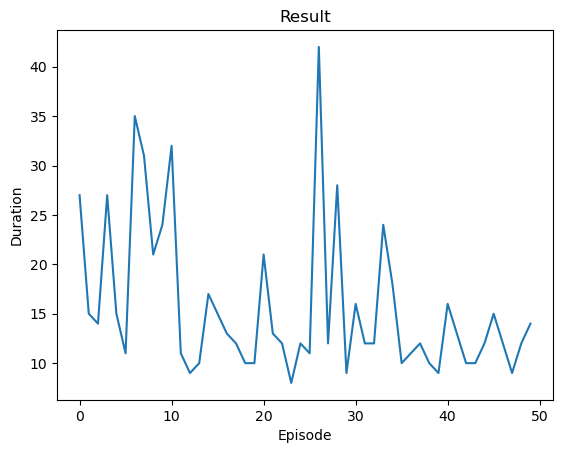

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # (정책 네트워크에서) 최적화 한단계 수행
        optimize_model()

        # 목표 네트워크의 가중치를 소프트 업데이트
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

다음은 전체 결과 데이터 흐름을 보여주는 다이어그램입니다.

![](https://tutorials.pytorch.kr/_static/img/reinforcement_learning_diagram.jpg)

행동은 무작위 또는 정책에 따라 선택되어, gym 환경에서 다음 단계 샘플을
가져옵니다. 결과를 재현 메모리에 저장하고 모든 반복에서 최적화 단계를
실행합니다. 최적화는 재현 메모리에서 무작위 배치를 선택하여 새 정책을
학습합니다. \"이전\"의 target\_net은 최적화에서 기대 Q 값을 계산하는
데에도 사용됩니다. 목표 네트워크 가중치의 소프트 업데이트는 매
단계(step)마다 수행됩니다.
